## neural_network

In [27]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from datetime import datetime
import pandas_profiling as ppf
from tensorboardX import SummaryWriter
writer=SummaryWriter(logdir='./neuron')

ALL=pd.read_csv(r'./data/created_data/logistic_final.csv').reset_index(drop=True).set_index('ID')

y=ALL['flag'].to_numpy()
train_X,val_X, train_y, val_y = train_test_split(ALL.drop(columns='flag'),y, test_size=0.30, random_state=0)

class CompanyDataset(Dataset):
    def __init__(self, X, Y):

        self.x = X.copy().values.astype(np.float32)
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):

        return self.x[idx],self.y[idx]

train_ds = CompanyDataset(train_X, train_y,)#embedded_col_names
valid_ds = CompanyDataset(val_X,val_y,)#embedded_col_names

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()

class FlagModel(nn.Module): 
    def __init__(self,n):
        super().__init__()
     
        self.lin1 = nn.Linear(n, 200)  
        self.lin2 = nn.Linear(200, 70)
        self.lin3 = nn.Linear(70, 2)

        self.bn2 = nn.BatchNorm1d(200)
        self.bn3 = nn.BatchNorm1d(70)
        

        self.drops = nn.Dropout(0.3)
        

    def forward(self,x): 

        x = F.relu(self.lin1(x))  #线性层并激活
        x = self.drops(x)        #drop_out
        
        x = self.bn2(x)         #标准化
        x = F.relu(self.lin2(x)) #线性层并激活
        x = self.drops(x)        #drop_out
        x = self.bn3(x)          #标准化
        x = self.lin3(x)         #线性层
#         x=torch.sigmoid(x)
        return x

model = FlagModel(12)
to_device(model, device)

def get_optimizer(model, lr = 0.001, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters()) #filter过滤序列，留下True
    optim = torch_optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def train_model(model, optim, train_dl,i):
    model.train()
    total = 0
    sum_loss = 0
    for x1, y in train_dl:
        batch = y.shape[0]
        output = model(x1)
        y=y.long()
        loss = F.cross_entropy(output, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
    writer.add_scalar('train_loss',sum_loss/total,i)
    return sum_loss/total
def val_loss(model, valid_dl,i):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x1,y in valid_dl:
        current_batch_size = y.shape[0]
        out = model(x1)
        y=y.long()
        loss = F.cross_entropy(out, y)
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.max(out, 1)[1]
        correct += (pred == y).float().sum().item()
#         correct = torch.mean((pred == y).float())
    writer.add_scalar('valid_loss',sum_loss/total,i)
    writer.add_scalar('valid_acc',correct/total,i)
    print("valid loss %f and accuracy %f " % (sum_loss/total, correct/total))
    return sum_loss/total, correct/total

def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl,i)
        print("training loss: ", loss)
        _,acc=val_loss(model, valid_dl,i)
        if acc>0.992:
            break
    return 
batch_size = 1000
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,shuffle=True)
train_dl = DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl,device)
train_loop(model, epochs=1000, lr=0.0001, wd=0.05)

training loss:  0.6466875055363447
valid loss 0.571338 and accuracy 0.781713 
training loss:  0.5270206096687642
valid loss 0.454639 and accuracy 0.840203 
training loss:  0.4607966051888182
valid loss 0.398584 and accuracy 0.867779 
training loss:  0.41333284299372364
valid loss 0.354675 and accuracy 0.884761 
training loss:  0.3760315582463465
valid loss 0.316480 and accuracy 0.908926 
training loss:  0.3447422012610256
valid loss 0.288969 and accuracy 0.922569 
training loss:  0.3190244728377965
valid loss 0.265451 and accuracy 0.930261 
training loss:  0.29830814337720024
valid loss 0.241914 and accuracy 0.937300 
training loss:  0.27680253226292983
valid loss 0.227495 and accuracy 0.941001 
training loss:  0.2612551061675165
valid loss 0.210494 and accuracy 0.944630 
training loss:  0.24494338234692042
valid loss 0.201078 and accuracy 0.945573 
training loss:  0.23475687898453768
valid loss 0.190259 and accuracy 0.949492 
training loss:  0.22149084202016198
valid loss 0.181957 and

training loss:  0.06181763427661168
valid loss 0.054994 and accuracy 0.982729 
training loss:  0.0611133094422684
valid loss 0.052337 and accuracy 0.984906 
training loss:  0.05861138408176719
valid loss 0.051243 and accuracy 0.984107 
training loss:  0.05951001420503552
valid loss 0.052292 and accuracy 0.986647 
training loss:  0.06032081228221751
valid loss 0.055115 and accuracy 0.983019 
training loss:  0.06010699561688137
valid loss 0.055900 and accuracy 0.982148 
training loss:  0.05699296689665502
valid loss 0.048643 and accuracy 0.987808 
training loss:  0.05898426991490338
valid loss 0.051376 and accuracy 0.988607 
training loss:  0.05886859940479956
valid loss 0.048817 and accuracy 0.987010 
training loss:  0.0592263220765341
valid loss 0.047968 and accuracy 0.986720 
training loss:  0.05630592988865219
valid loss 0.047443 and accuracy 0.986720 
training loss:  0.05689762032089298
valid loss 0.048300 and accuracy 0.988316 
training loss:  0.05790912573498696
valid loss 0.04974

In [28]:
for x1,y in valid_dl:
    break
writer.add_graph(model,(x1,))
writer.close()
torch.save(model.state_dict(), "p99383p.npy")
# model.load_state_dict(torch.load("p99383p.npy"))

In [29]:
writer.close()

## logistic regression

In [20]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pandas_profiling as ppf
# from tensorboardX import SummaryWriter
from sklearn.model_selection import train_test_split
# writer=SummaryWriter(logdir='./logistic_summary')

ALL=pd.read_csv(r'./data/created_data/logistic_final.csv').reset_index(drop=True).set_index('ID')

y=ALL['flag']
train_X,val_X, train_y, val_y = train_test_split(ALL.drop(columns='flag'),y, test_size=0.30, random_state=0)

class LR(nn.Module):
    def __init__(self):
        super(LR,self).__init__()
        self.fc=nn.Linear(12,2) # 由于27个维度已经固定了，所以这里写27
    def forward(self,x):
        x=self.fc(x)
        out=torch.sigmoid(x)
        return out


def test(pred,lab):
    t=pred.max(-1)[1]==lab
    return torch.mean(t.float())


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = get_default_device()

# 网络模型实例化
net=LR()
to_device(net, device)
# 使用CrossEntropyLoss损失
criterion=nn.CrossEntropyLoss() # BCEloss待测
# 优化器
optm=torch.optim.Adam(net.parameters(),lr=0.3) 
# 训练1500次
epochs=25000


for i in range(epochs):
#      指定模型为训练模式，计算梯度
    net.train()
#      输入值都需要转化成torch的Tensor
    x=to_device(torch.from_numpy(train_X.values).float(),device)
    y=to_device(torch.from_numpy(train_y.values).long(),device)
#     输入数据
    y_hat=net(x)
#     计算损失
    loss=criterion(y_hat,y) 
#     前一步的损失清零
    optm.zero_grad() 
#     反向传播 
    loss.backward() 
#     更新参数
    optm.step() 
#     writer.add_scalar('tra_loss',loss,i)

#     if True:
    if (i+1)%100 ==0 : # 这里我们每100次输出相关的信息
#         指定模型为计算模式
        net.eval()
        test_in=to_device(torch.from_numpy(val_X.values).float(),device)
        test_l=to_device(torch.from_numpy(val_y.values).long(),device)
        test_out=net(test_in)
#          使用我们的测试函数计算准确率
        accu=test(test_out,test_l)
#         writer.add_scalar('tes_loss',loss.item(),i)
#         writer.add_scalar('tes_acc',accu,i)
        print("Epoch:{},Loss:{:.4f},Accuracy：{:.4f}".format(i+1,loss.item(),accu))    

Epoch:100,Loss:0.3896,Accuracy：0.9693
Epoch:200,Loss:0.3743,Accuracy：0.9673
Epoch:300,Loss:0.3664,Accuracy：0.9687
Epoch:400,Loss:0.3615,Accuracy：0.9689
Epoch:500,Loss:0.3580,Accuracy：0.9702
Epoch:600,Loss:0.3553,Accuracy：0.9710
Epoch:700,Loss:0.3532,Accuracy：0.9720
Epoch:800,Loss:0.3515,Accuracy：0.9722
Epoch:900,Loss:0.3500,Accuracy：0.9728
Epoch:1000,Loss:0.3488,Accuracy：0.9736
Epoch:1100,Loss:0.3477,Accuracy：0.9738
Epoch:1200,Loss:0.3468,Accuracy：0.9741
Epoch:1300,Loss:0.3459,Accuracy：0.9745
Epoch:1400,Loss:0.3452,Accuracy：0.9747
Epoch:1500,Loss:0.3445,Accuracy：0.9748
Epoch:1600,Loss:0.3438,Accuracy：0.9753
Epoch:1700,Loss:0.3433,Accuracy：0.9757
Epoch:1800,Loss:0.3427,Accuracy：0.9758
Epoch:1900,Loss:0.3422,Accuracy：0.9761
Epoch:2000,Loss:0.3417,Accuracy：0.9763
Epoch:2100,Loss:0.3413,Accuracy：0.9763
Epoch:2200,Loss:0.3408,Accuracy：0.9764
Epoch:2300,Loss:0.3404,Accuracy：0.9766
Epoch:2400,Loss:0.3400,Accuracy：0.9769
Epoch:2500,Loss:0.3397,Accuracy：0.9769
Epoch:2600,Loss:0.3393,Accuracy：0.

Epoch:20900,Loss:0.3279,Accuracy：0.9862
Epoch:21000,Loss:0.3279,Accuracy：0.9861
Epoch:21100,Loss:0.3279,Accuracy：0.9863
Epoch:21200,Loss:0.3279,Accuracy：0.9861
Epoch:21300,Loss:0.3279,Accuracy：0.9863
Epoch:21400,Loss:0.3279,Accuracy：0.9863
Epoch:21500,Loss:0.3279,Accuracy：0.9863
Epoch:21600,Loss:0.3279,Accuracy：0.9863
Epoch:21700,Loss:0.3279,Accuracy：0.9864
Epoch:21800,Loss:0.3279,Accuracy：0.9863
Epoch:21900,Loss:0.3279,Accuracy：0.9864
Epoch:22000,Loss:0.3279,Accuracy：0.9863
Epoch:22100,Loss:0.3279,Accuracy：0.9863
Epoch:22200,Loss:0.3279,Accuracy：0.9863
Epoch:22300,Loss:0.3279,Accuracy：0.9863
Epoch:22400,Loss:0.3279,Accuracy：0.9864
Epoch:22500,Loss:0.3279,Accuracy：0.9863
Epoch:22600,Loss:0.3279,Accuracy：0.9862
Epoch:22700,Loss:0.3279,Accuracy：0.9863
Epoch:22800,Loss:0.3279,Accuracy：0.9863
Epoch:22900,Loss:0.3279,Accuracy：0.9863
Epoch:23000,Loss:0.3279,Accuracy：0.9864
Epoch:23100,Loss:0.3278,Accuracy：0.9863
Epoch:23200,Loss:0.3278,Accuracy：0.9863
Epoch:23300,Loss:0.3278,Accuracy：0.9864


In [30]:
net.state_dict()

OrderedDict([('fc.weight',
              tensor([[ 7.3093e+00,  1.0684e+01, -1.1756e+01,  3.2961e+02, -2.7805e+01,
                        7.7675e+02, -3.6712e+00,  7.8851e+00, -4.5155e+00, -7.9512e-01,
                        4.1711e+00, -1.0358e+01],
                      [-1.1238e+00,  3.6656e-01,  1.1861e+01, -1.0439e+02,  1.5735e+01,
                       -9.0467e+02,  2.1425e+01, -2.6455e+00, -3.5045e-01,  1.7111e+01,
                       -9.5384e+00,  1.1653e+01]], device='cuda:0')),
             ('fc.bias', tensor([ 414.1797, -405.8227], device='cuda:0'))])

## 由逻辑回归输出特征权重

In [31]:
weights=[i if i > 0 else -i for i in [int(i) for i in (net.state_dict()['fc.weight'].cpu().numpy()[1]*10000)]]
features=ALL.drop(columns='flag').columns.tolist()
dic = dict(zip(features, weights))  # 词频以字典形式存储

In [39]:
features=['负债总额度','股权融资成本','股权融资额度','净利润','利润总额','纳税总额','内部融资和贸易融资成本','内部融资和贸易融资额度','所有者权益合计','营业总收入','债权融资成本','债权融资额度']
dic = dict(zip(features, weights))

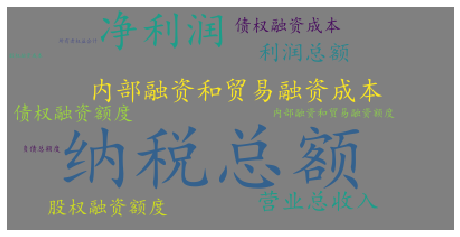

In [49]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image


image = Image.open('./data/created_data/timg.jfif')  # 作为背景轮廓图
graph = np.array(image)
# 参数分别是指定字体、背景颜色、最大的词的大小、使用给定图作为背景形状
wc = WordCloud(font_path='simkai.ttf', background_color='gray',max_words=2000,) #, mask=graph  
wc.generate_from_frequencies(dic)  # 根据给定词频生成词云
image_color = ImageColorGenerator(graph)
plt.imshow(wc)
plt.axis("off")  # 不显示坐标轴
plt.show()
wc.to_file('./data/created_data/wordcloudgray.png')  # 图片命名


In [42]:
# ?WordCloud
aaaa=[i for i in list(net.state_dict()['fc.weight'].cpu().numpy()[1])]

In [43]:
di=dict(zip(features, aaaa))

In [44]:
di

{'负债总额度': -1.1237559,
 '股权融资成本': 0.36655867,
 '股权融资额度': 11.861227,
 '净利润': -104.38966,
 '利润总额': 15.735193,
 '纳税总额': -904.6744,
 '内部融资和贸易融资成本': 21.4252,
 '内部融资和贸易融资额度': -2.6454968,
 '所有者权益合计': -0.35045236,
 '营业总收入': 17.110937,
 '债权融资成本': -9.538354,
 '债权融资额度': 11.653447}